In [4]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from utils.scheduler import *
import matplotlib.pyplot as plt
from datasets import load_dataset
from utils.modelsother import *
from torch.utils.tensorboard import SummaryWriter

In [5]:
writer = SummaryWriter('./runs')

In [6]:
T = 100
img_size = 64

Text(0, 0.5, 'alpha_hat(t)')

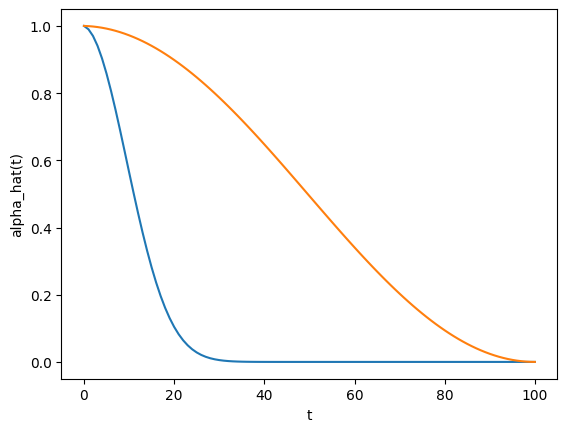

In [7]:
# Schedules
a = NoiseScheduler(T=T, type='linear', initial_beta=1, final_beta=0)
b = NoiseScheduler(T=T, type='quadratic', initial_beta=1e-4, final_beta=0)

plt.plot(a.get_schedule())
plt.plot(b.get_schedule())
plt.xlabel('t')
plt.ylabel('alpha_hat(t)')

In [8]:
# Dataset
dataset = load_dataset("huggan/smithsonian_butterflies_subset", split="train")

Repo card metadata block was not found. Setting CardData to empty.


In [9]:
preprocess = transforms.Compose(
    [
        transforms.Resize((img_size, img_size)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ]
)

def transform(examples):
    images = [preprocess(image.convert("RGB")) for image in examples["image"]]
    return {"images": images}

dataset.set_transform(transform)

train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=4, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.94509804..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9764706..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9607843..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.94509804..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9843137..1.0].


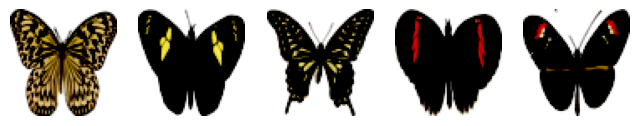

In [10]:
fig, axs = plt.subplots(1, 5, figsize=(8, 2))
for i, image in enumerate(dataset[:5]["images"]):
    axs[i].imshow(image.permute(1,2,0))
    axs[i].set_axis_off()

In [ ]:
# T steps of the forward process
fig, axs = plt.subplots(1, T+1, figsize=(16, 4))
for t in range(0,T+1):
    noised_image = a.add_noise(image=image, t=t)
    axs[t].imshow(noised_image.permute(1,2,0))
    axs[t].set_axis_off()

In [ ]:
# T steps of the forward process
fig, axs = plt.subplots(1, T+1, figsize=(16, 4))
for t in range(0,T+1):
    noised_image = b.add_noise(image=image, t=t)
    axs[t].imshow(noised_image.permute(1,2,0))
    axs[t].set_axis_off()

In [11]:
# model = UNet(in_channels=3, out_channels=3)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = UNet().to(device)

img = torch.randn((1,3,64,64), device=device)
# out = model(img)
out = model(img, t=torch.randint(low=1,high=T+1, size=(1,), device=device))

print(img.shape)
print(out.shape)

torch.Size([1, 3, 64, 64])
torch.Size([1, 3, 64, 64])


In [13]:
# Training loop
loss_fcn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


def train_epoch(epoch_id):
    epoch_loss = 0
    for i, inputs in enumerate(train_dataloader):
        # Take a batch of images
        imgs = inputs['images'].to(device)
        optimizer.zero_grad()
        
        # For each image sample a different time moment
        t = torch.randint(low=1,high=T+1, size=(imgs.shape[0],), device=device) # batch size
        
        # Noise each image in batch according to its time
        noise = torch.randn_like(imgs, device=device)
        alpha_hats = b.get_schedule().to(device)[t]
        imgs = imgs*alpha_hats[:,None,None,None] + noise*torch.sqrt(1-alpha_hats[:,None,None,None])
        
        # Predict the noise
        noise_pred = model(imgs, t)
        
        # Compute loss and backpropagate
        loss = loss_fcn(noise, noise_pred)
        loss.backward()
        
        # Update model weights
        optimizer.step()
        
        # Report loss
        epoch_loss += loss.item()
        
        print(f'Loss epoch[{epoch_id}], step[{epoch_id*len(train_dataloader) + i}]: {loss.item()}')

        writer.add_scalar('Training Loss', loss.item(), epoch_id*len(train_dataloader) + i)
        
    return epoch_loss/len(train_dataloader)

In [15]:
num_epochs = 1

loss = []
for i in range(num_epochs):
    model.train()
    epoch_loss = train_epoch(i)
    
    loss.append(epoch_loss)

Loss epoch 0: 0.3038129210472107
Loss epoch 0: 0.12512849271297455
Loss epoch 0: 0.3033677935600281
Loss epoch 0: 0.16500459611415863
Loss epoch 0: 0.2681901156902313
Loss epoch 0: 0.33311793208122253
Loss epoch 0: 0.1031741350889206
Loss epoch 0: 0.22714051604270935
Loss epoch 0: 0.11898736655712128
Loss epoch 0: 0.11870651692152023
Loss epoch 0: 0.18216416239738464
Loss epoch 0: 0.12622326612472534
Loss epoch 0: 0.1156272292137146
Loss epoch 0: 0.103208988904953
Loss epoch 0: 0.17083674669265747
Loss epoch 0: 0.2792176604270935
Loss epoch 0: 0.4433833062648773
Loss epoch 0: 0.20322251319885254
Loss epoch 0: 0.09974025189876556
Loss epoch 0: 0.36328959465026855
Loss epoch 0: 0.12429653108119965
Loss epoch 0: 0.11320362985134125
Loss epoch 0: 0.2178981751203537
Loss epoch 0: 0.11238553375005722
Loss epoch 0: 0.12203352153301239
Loss epoch 0: 0.1384398639202118
Loss epoch 0: 0.10840804874897003
Loss epoch 0: 0.1904641091823578
Loss epoch 0: 0.34409183263778687
Loss epoch 0: 0.3309592008

In [17]:
torch.save(model.state_dict(), './model_weights.pth')

In [ ]:
UNet(device='cpu')(torch.randn((1,3,64,64),device='cpu'),t=torch.randint(low=1,high=T+1, size=(1,), device='cpu')).shape